In [1]:
import os

import numpy as np
import pandas as pd
import rasterio as rio
import geopandas as gp
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn import metrics
from osgeo import gdal, osr
from scipy import stats, spatial, signal, fftpack

import warnings
warnings.filterwarnings("ignore")

In [8]:

# Functions

def write_raster(array,gdf,outfn):
	'''
	converts a numpy array and a geopandas gdf to a geotiff
	Data values are stored in np.array
	spatial coordinates stored in gdf
	outfn - outpath
	'''

	xmin, ymin = gdf.bounds.minx.values[0], gdf.bounds.miny.values[0]
	xmax, ymax = gdf.bounds.maxx.values[0], gdf.bounds.maxy.values[0]
	nrows, ncols = array.shape
	xres = (xmax-xmin)/float(ncols)
	yres = (ymax-ymin)/float(nrows)
	geotransform =(xmin,xres,0,ymax,0, -yres)   

	output_raster = gdal.GetDriverByName('GTiff').Create(outfn,ncols, nrows, 1 , gdal.GDT_Float32)  # Open the file
	output_raster.SetGeoTransform(geotransform)  # Specify coords
	srs = osr.SpatialReference()                 # Establish encoding
	srs.ImportFromEPSG(4326)                     # WGS84 lat long
	output_raster.SetProjection(srs.ExportToWkt() )   # Export coordinate system 
	output_raster.GetRasterBand(1).WriteArray(array)   # Write array to raster

	print("wrote {}".format(outfn))
	return outfn


def calc_nbins(N):

	'''
	A. Hacine-Gharbi, P. Ravier, "Low bias histogram-based estimation of mutual information for feature selection", Pattern Recognit. Lett (2012).
	'''
	ee = np.cbrt(8 + 324*N + 12*np.sqrt(36*N + 729*N**2))
	bins = np.round(ee/6 + 2/(3*ee) + 1/3)

	return int(bins)

def calc_mi(imstack, inflow):

	# Build the out image
	mi_im = np.zeros_like(np.mean(imstack, axis = 2))

	rows, cols, time = imstack.shape
	px_ts = []
	rclist = []

	# extract pixelwise timeseries
	for row in range(rows):
		for col in range(cols):
			ts_arr = imstack[row,col,:]

			if not np.isnan(ts_arr).all():
				px_ts.append(pd.Series(ts_arr))
				rclist.append([row,col])
			else:
				px_ts.append(pd.Series(np.zeros_like(ts_arr)))
				rclist.append([row,col])

	pxdf = pd.concat(px_ts, axis = 1)
	pxdf.columns = pxdf.columns.map(str)

	# Populate the per-pixel lags 
	for rc, dfcolidx in tqdm(list(zip(rclist,pxdf.columns))):

		tempdf = pd.DataFrame([pxdf[dfcolidx].copy(),inflow]).T
		tempdf.columns = ['var','q']

		# get n bins
		nbins = calc_nbins(len(tempdf))

		# compute mutual info
		try: 
			mi = metrics.mutual_info_score(tempdf['var'].value_counts(normalize=True,bins = nbins),tempdf['q'].value_counts(normalize=True,bins = nbins))
		except:
			mi = np.nan

		# fill ims
		rowidx, colidx = rc
		mi_im[rowidx,colidx] = mi

	return mi_im
def normalize(x):
	return(x-np.nanmin(x))/(np.nanmax(x)- np.nanmin(x))

def calc_xcorr_fft(imstack, qarr):
	rows, cols, time = imstack.shape
	px_ts = []
	rclist = []

	# extract pixelwise timeseries
	for row in range(rows):
		for col in range(cols):
			ts_arr = imstack[row,col,:]

			if not np.isnan(ts_arr).all():
				px_ts.append(pd.Series(ts_arr))
				rclist.append([row,col])
			else:
				px_ts.append(pd.Series(np.zeros_like(ts_arr)))
				rclist.append([row,col])

	pxdf = pd.concat(px_ts, axis = 1)
	pxdf.columns = pxdf.columns.map(str)

	# Build the out image
	lagim = np.zeros_like(np.mean(imstack, axis = 2))
	corrim = np.zeros_like(np.mean(imstack, axis = 2))
	pvalim = np.zeros_like(np.mean(imstack, axis = 2))

	# Populate the per-pixel lags 
	for rc, dfcolidx in tqdm(list(zip(rclist,pxdf.columns))):

		a=pxdf[dfcolidx].values
		b=qarr.copy()

		# compute shift + corr mag

		# Shift
		try:
			A = fftpack.fft(normalize(a))
			B = fftpack.fft(normalize(b))
			Ar = -A.conjugate()
			shiftval = np.argmax(np.abs(fftpack.ifft(Ar*B))[:365]) # 365 day buffer for reasonable results 
		except:
			shiftval = np.nan

		try:
			corrcoef = stats.pearsonr(a,b)
			corr = corrcoef[0]
			pval = corrcoef[1]
		except:
			pval = np.nan
			corr = np.nan

		# fill ims
		rowidx, colidx = rc
		lagim[rowidx,colidx] = shiftval
		corrim[rowidx,colidx] = abs(corr)
		pvalim[rowidx,colidx] = pval

	return lagim.astype(float), corrim.astype(float), pvalim.astype(float)

def fft_wrapper(imstack,qarr):

	lag_im, corr_im, pval_im = calc_xcorr_fft(imstack,qarr)

	# Get mean of theentire stack 
	im_mean = np.nanmean(imstack, axis = 2)

	# Mask zeros
	# lag_im, corr_im = [np.where(x==0, np.nan, x) for x in [lag_im,corr_im]]

	# Filter lag and cor by >0.001 mm tottalthreshold for smlt and >1 for precip 
	lag_im, corr_im = [np.where(im_mean<np.nanpercentile(im_mean,5), np.nan, x) for x in [lag_im,corr_im]]

	# Filter lag and cor by P value >0.05
	lag_im, corr_im = [np.where(pval_im>0.05, np.nan, x) for x in [lag_im,corr_im]]

	lag_im = np.where(np.isnan(pval_im), np.nan, lag_im)

	return lag_im, corr_im

def mi_wrapper(imstack,qarr):

	mi_im = calc_mi(imstack,qarr)

	# Get mean of theentire stack 
	im_sum = np.nansum(imstack, axis = 2)

	# mask where sum is zero 
	mi_im = np.where(im_sum==0, np.nan, mi_im)

	# Mask the other nans 
	mi_im = np.where(np.isnan(im_sum), np.nan, mi_im)
	
	return mi_im

In [9]:
def main(stn_id, baseflow = True):

    print("=======" * 15)
    print("PROCESSING: {}".format(stn_id))
    print("=======" * 15)

    # Read runoff
    if baseflow:
        rdf = pd.read_csv("../data/baseflow_sep/baseflow_mm.csv")
    else:
        rdf = pd.read_csv("../data/baseflow_sep/surface_runoff_mm.csv")    
    rdf['date'] = pd.to_datetime(rdf['date'])
    rdf.set_index("date", inplace = True)    

    # Read rainfall and snowmelt data
    smlt_fn_1d = "../data/Watersheds/1d/{}_1d_smlt.npy".format(stn_id)
    prcp_fn_1d = "../data/Watersheds/1d/{}_1d_prcp.npy".format(stn_id)

    smlt_1d = np.load(smlt_fn_1d)
    prcp_1d = np.load(prcp_fn_1d)

    # filter the runoff data to select watershed

    # if station is PAR, we need to chop off 2017 - 2021
    if stn_id == "PAR":
        df = rdf[stn_id]
        mask = (df.index <= "2016-09-30") 
        stn_r_df = df.loc[mask].interpolate(how = 'linear')
        n_days = len(stn_r_df)
        smlt_1d = smlt_1d[:,:,:n_days]
        prcp_1d = prcp_1d[:,:,:n_days]
    else:
        stn_r_df = rdf[stn_id].interpolate(how = 'linear')

    qarr = stn_r_df.values
    
    # Process the 1d ims
    print("Computing Cross Correlation")
    smlt_1d_lag, smlt_1d_cor = fft_wrapper(smlt_1d,qarr) 
    prcp_1d_lag, prcp_1d_cor = fft_wrapper(prcp_1d,qarr) 
    
    return smlt_1d_lag, smlt_1d_cor, prcp_1d_lag, prcp_1d_cor

#     print("Computing Mutual Info")
#     smlt_1d_mi = mi_wrapper(smlt_1d,qarr)
#     prcp_1d_mi = mi_wrapper(prcp_1d,qarr)

#     # write results
#     stn_gdf = gp.read_file("../shape/{}.shp".format(stn_id))
    
#     outdir = "../results/baseflow"
#     if not os.path.exists(outdir):
#         os.mkdir(outdir)
    
#     write_raster(smlt_1d_mi,stn_gdf, os.path.join(outdir,"{}_smlt_1d_mi.tif".format(stn_id)))
#     write_raster(smlt_1d_lag,stn_gdf, os.path.join(outdir,"{}_smlt_1d_lag.tif".format(stn_id)))
#     write_raster(smlt_1d_cor,stn_gdf, os.path.join(outdir,"{}_smlt_1d_cor.tif".format(stn_id)))
#     write_raster(prcp_1d_mi,stn_gdf, os.path.join(outdir,"{}_prcp_1d_mi.tif".format(stn_id)))
#     write_raster(prcp_1d_lag,stn_gdf, os.path.join(outdir,"{}_prcp_1d_lag.tif".format(stn_id)))
#     write_raster(prcp_1d_cor,stn_gdf, os.path.join(outdir,"{}_prcp_1d_cor.tif".format(stn_id)))

PROCESSING: ENG
(6575,)
Computing Cross Correlation


100%|██████████| 8850/8850 [00:11<00:00, 747.88it/s]


PROCESSING: ENG
(6575,)
Computing Cross Correlation


100%|██████████| 8850/8850 [00:11<00:00, 750.40it/s]


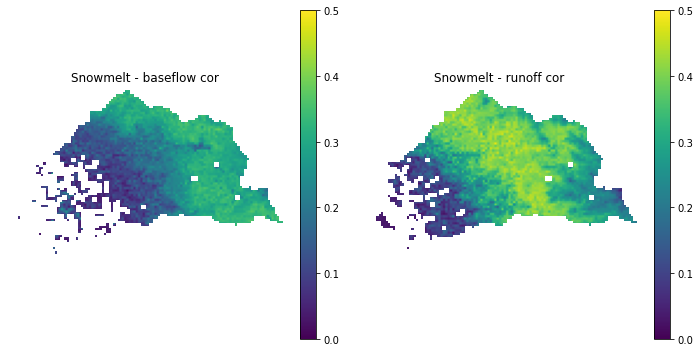

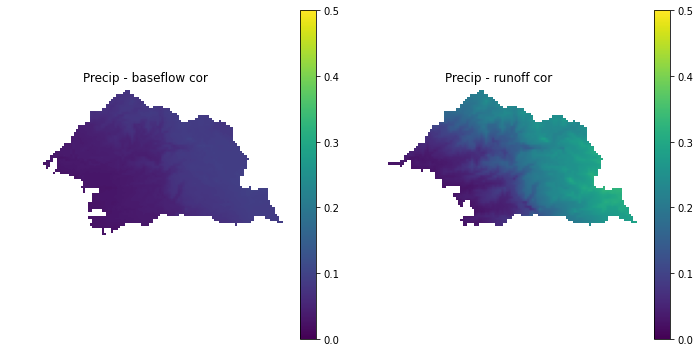

PROCESSING: PAR
(4749,)
Computing Cross Correlation


100%|██████████| 5290/5290 [00:05<00:00, 886.29it/s]


PROCESSING: PAR
(4749,)
Computing Cross Correlation


100%|██████████| 5290/5290 [00:06<00:00, 864.19it/s]


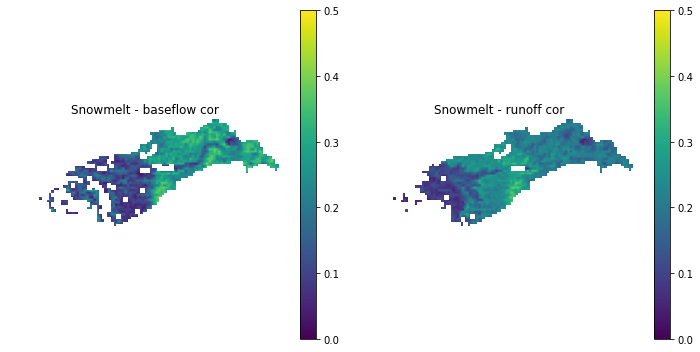

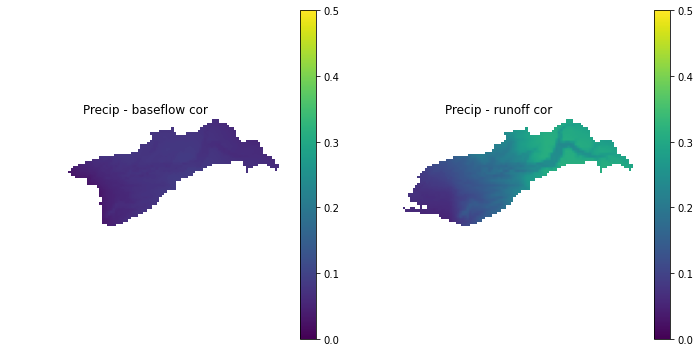

PROCESSING: MIL
(6575,)
Computing Cross Correlation


100%|██████████| 11921/11921 [00:16<00:00, 720.54it/s]


PROCESSING: MIL
(6575,)
Computing Cross Correlation


100%|██████████| 11921/11921 [00:16<00:00, 709.02it/s]


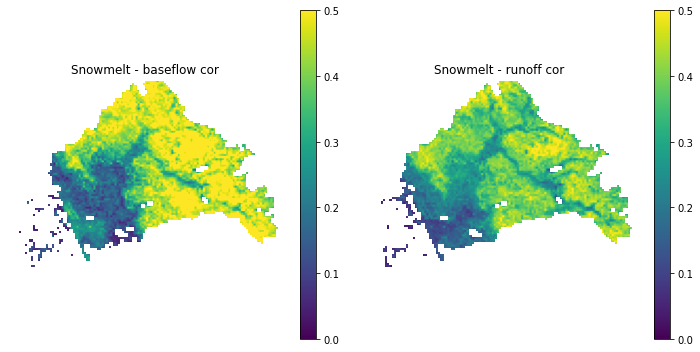

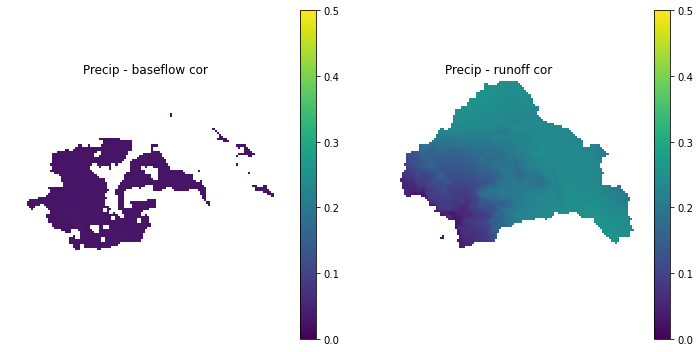

PROCESSING: ISB
(6575,)
Computing Cross Correlation


100%|██████████| 12400/12400 [00:18<00:00, 674.41it/s]


PROCESSING: ISB
(6575,)
Computing Cross Correlation


100%|██████████| 12400/12400 [00:18<00:00, 673.95it/s]


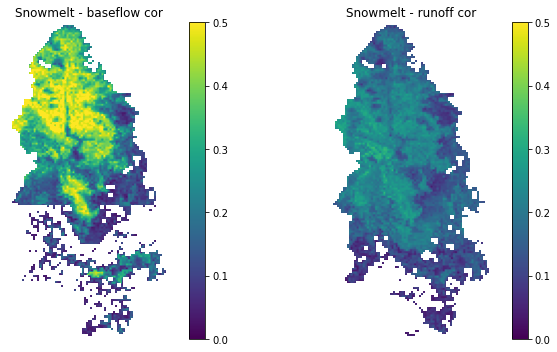

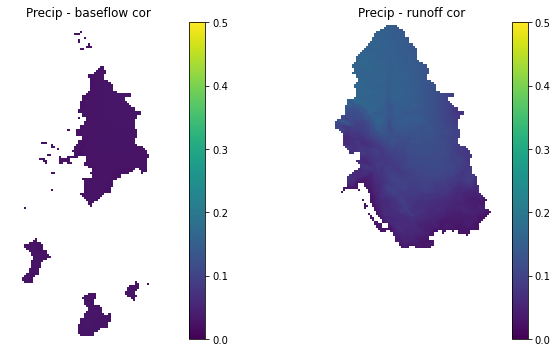

PROCESSING: DNP
(6575,)
Computing Cross Correlation


100%|██████████| 10780/10780 [00:15<00:00, 695.12it/s]


PROCESSING: DNP
(6575,)
Computing Cross Correlation


100%|██████████| 10780/10780 [00:15<00:00, 676.31it/s]


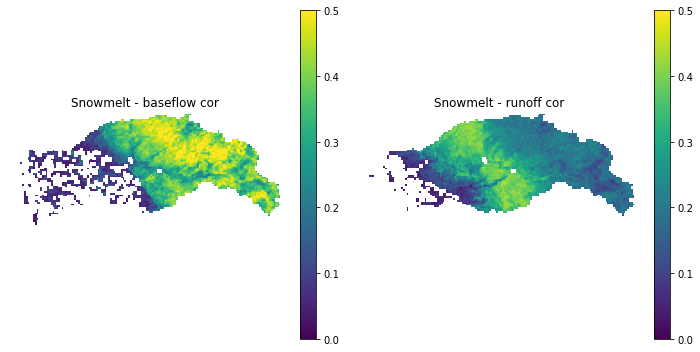

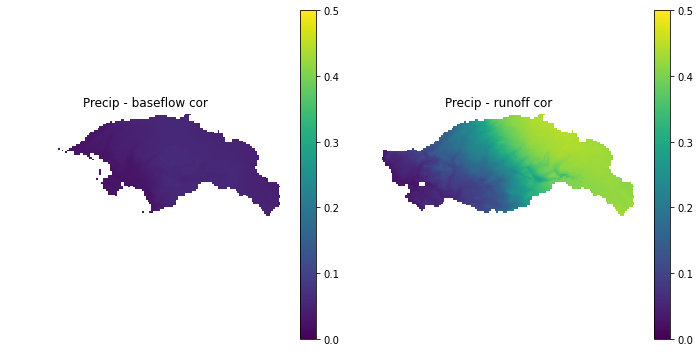

PROCESSING: NML
(6575,)
Computing Cross Correlation


100%|██████████| 8906/8906 [00:12<00:00, 688.52it/s]


PROCESSING: NML
(6575,)
Computing Cross Correlation


100%|██████████| 8906/8906 [00:12<00:00, 696.38it/s]


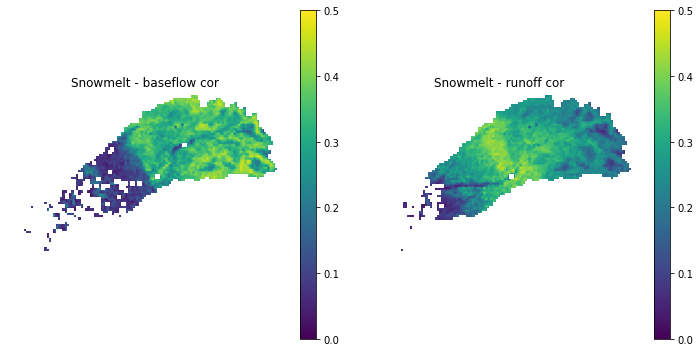

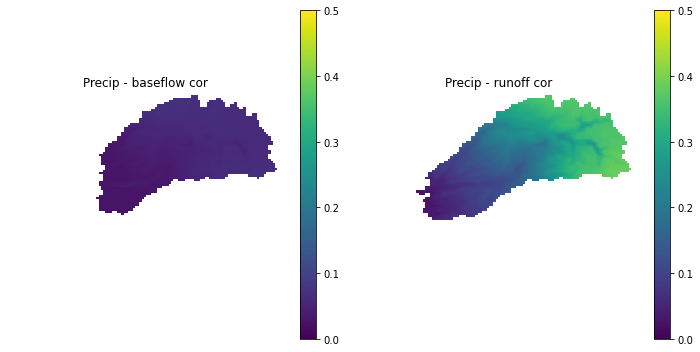

PROCESSING: ORO
(6575,)
Computing Cross Correlation


100%|██████████| 22196/22196 [00:32<00:00, 687.44it/s]


PROCESSING: ORO
(6575,)
Computing Cross Correlation


100%|██████████| 22196/22196 [00:36<00:00, 601.99it/s]


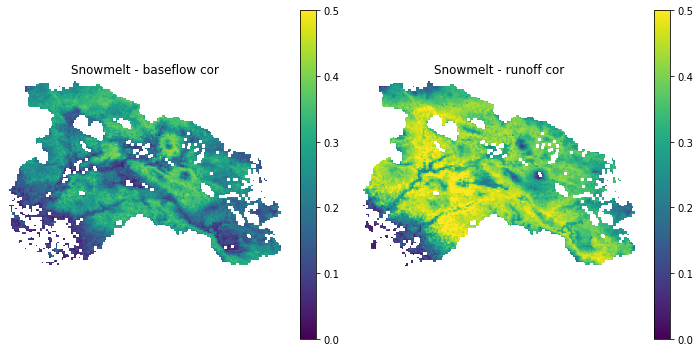

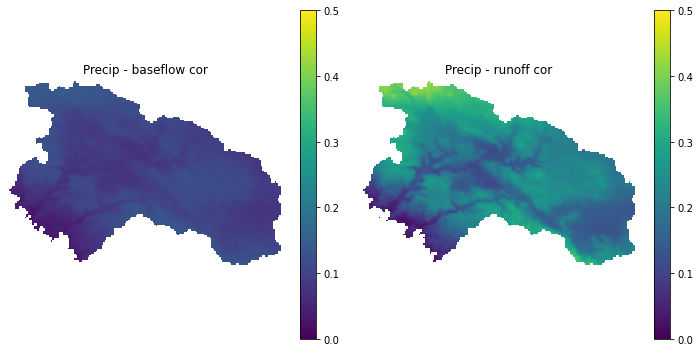

PROCESSING: FOL
(6575,)
Computing Cross Correlation


100%|██████████| 12642/12642 [00:18<00:00, 692.45it/s]


PROCESSING: FOL
(6575,)
Computing Cross Correlation


100%|██████████| 12642/12642 [00:18<00:00, 699.71it/s]


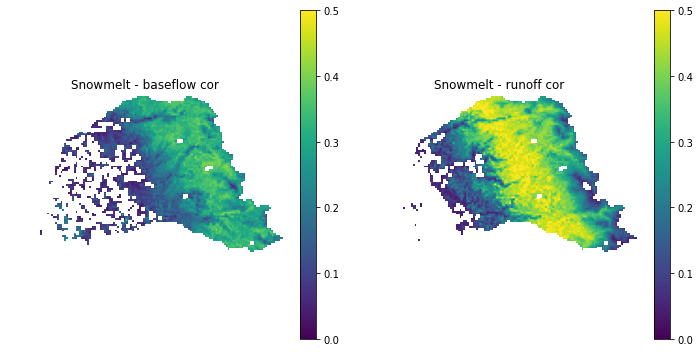

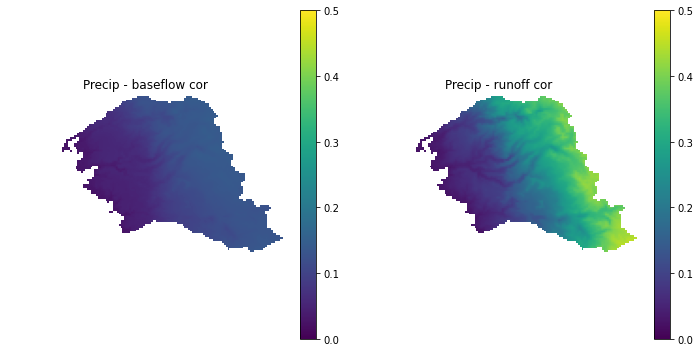

PROCESSING: TRM
(6575,)
Computing Cross Correlation


100%|██████████| 3132/3132 [00:04<00:00, 682.48it/s]


PROCESSING: TRM
(6575,)
Computing Cross Correlation


100%|██████████| 3132/3132 [00:04<00:00, 674.07it/s]


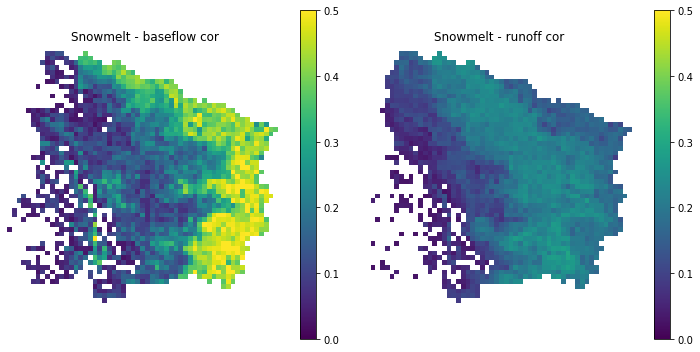

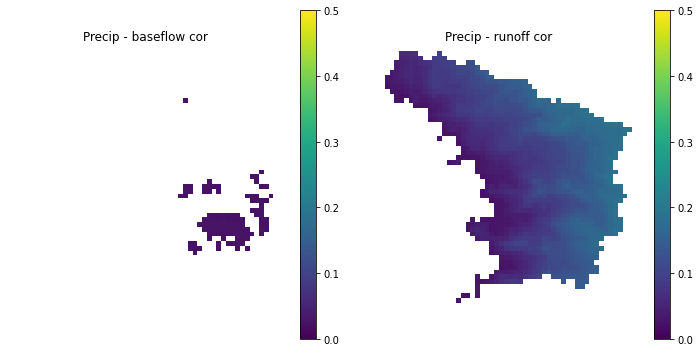

PROCESSING: SCC
(6575,)
Computing Cross Correlation


100%|██████████| 2444/2444 [00:03<00:00, 663.96it/s]


PROCESSING: SCC
(6575,)
Computing Cross Correlation


100%|██████████| 2444/2444 [00:03<00:00, 698.33it/s]


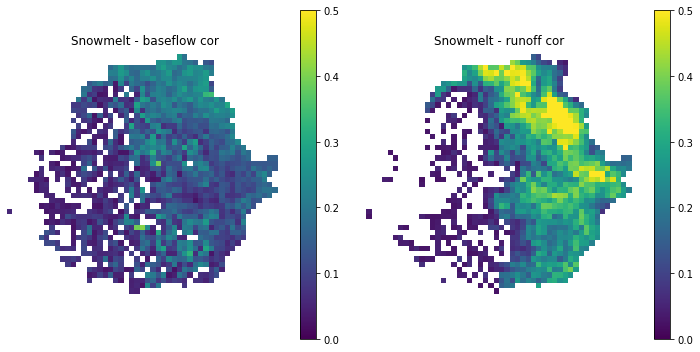

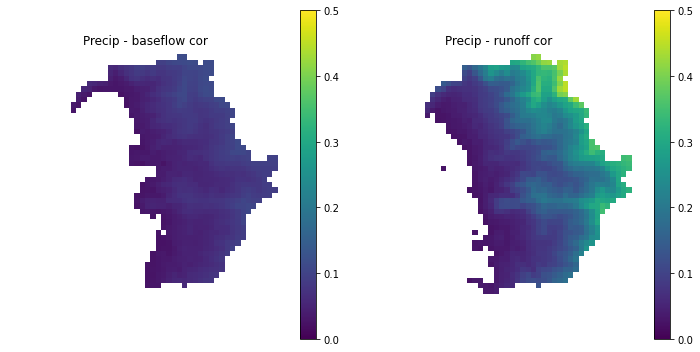

PROCESSING: PNF
(6575,)
Computing Cross Correlation


100%|██████████| 9825/9825 [00:13<00:00, 703.40it/s]


PROCESSING: PNF
(6575,)
Computing Cross Correlation


100%|██████████| 9825/9825 [00:13<00:00, 702.64it/s]


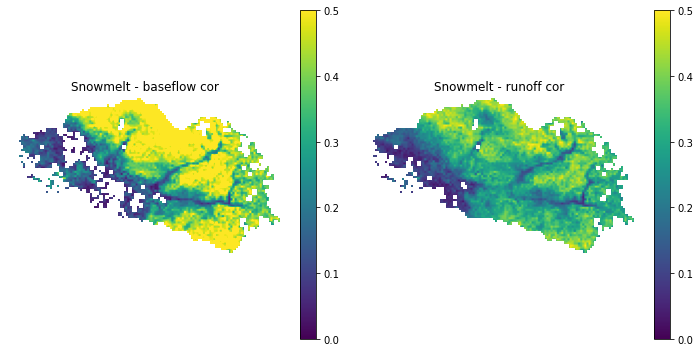

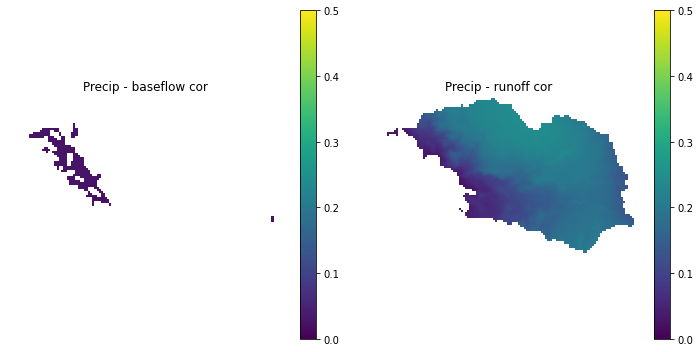

PROCESSING: NHG
(6575,)
Computing Cross Correlation


100%|██████████| 2940/2940 [00:04<00:00, 716.09it/s]


PROCESSING: NHG
(6575,)
Computing Cross Correlation


100%|██████████| 2940/2940 [00:04<00:00, 675.80it/s]


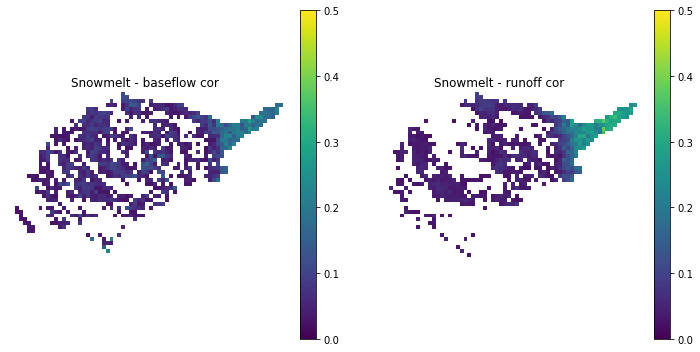

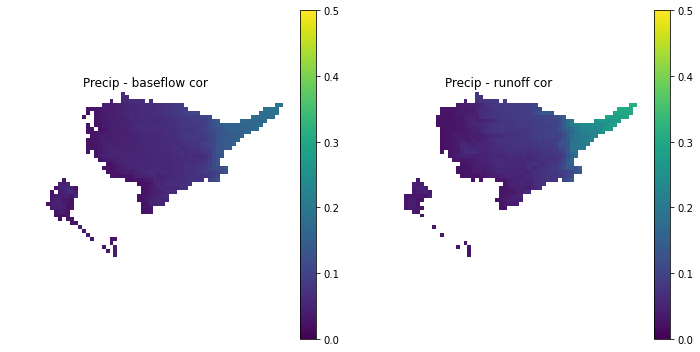

PROCESSING: SHA
(6575,)
Computing Cross Correlation


100%|██████████| 68967/68967 [01:39<00:00, 690.18it/s]


PROCESSING: SHA
(6575,)
Computing Cross Correlation


100%|██████████| 68967/68967 [01:40<00:00, 689.58it/s]


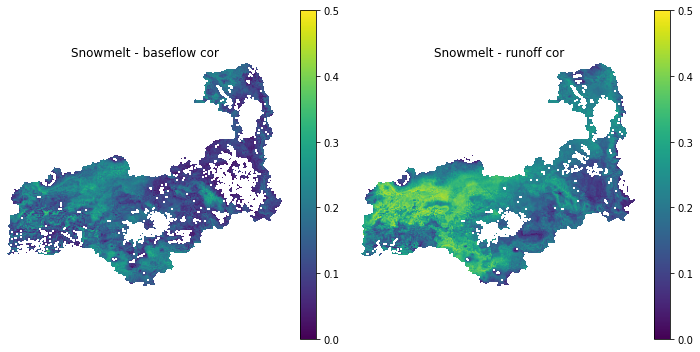

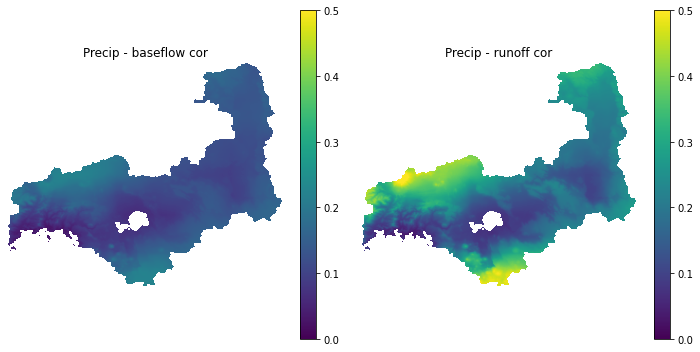

In [11]:
# Read watersheds
gdf = gp.read_file("../shape/sierra_catchments.shp")

stids_all = list(gdf['stid'].values)
nodata_stids = ["MCR", "CFW"]

stids = [x for x in stids_all if x not in nodata_stids]

for stid in stids[:]:
    smlt_1d_lag_bf, smlt_1d_cor_bf, prcp_1d_lag_bf, prcp_1d_cor_bf = main(stid, baseflow = True)
    smlt_1d_lag_sr, smlt_1d_cor_sr, prcp_1d_lag_sr, prcp_1d_cor_sr = main(stid, baseflow = False)
    
    # plot smlt
    plt.figure(figsize = (10,5))

    plt.subplot(121)
    plt.title("Snowmelt - baseflow cor")
    plt.imshow(smlt_1d_cor_bf, vmin = 0, vmax = 0.5)
    plt.axis("off")
    plt.colorbar()

    plt.subplot(122)
    plt.title("Snowmelt - runoff cor")
    plt.imshow(smlt_1d_cor_sr, vmin = 0, vmax = 0.5)
    plt.axis("off")
    plt.colorbar()

    plt.tight_layout()
    plt.show()
    
    # prcp
    plt.figure(figsize = (10,5))

    plt.subplot(121)
    plt.title("Precip - baseflow cor")
    plt.imshow(prcp_1d_cor_bf, vmin = 0, vmax = 0.5)
    plt.axis("off")
    plt.colorbar()

    plt.subplot(122)
    plt.title("Precip - runoff cor")
    plt.imshow(prcp_1d_cor_sr, vmin = 0, vmax = 0.5)
    plt.axis("off")
    plt.colorbar()

    plt.tight_layout()
    plt.show()